
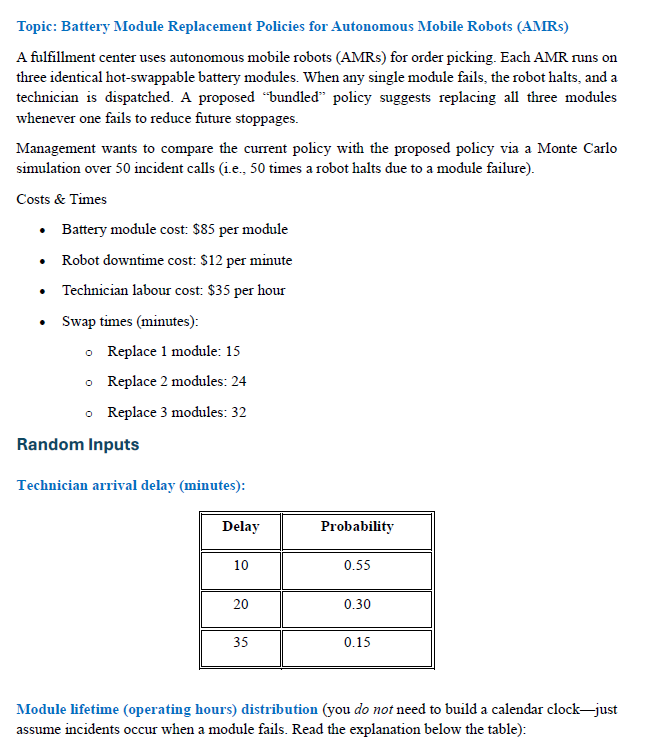

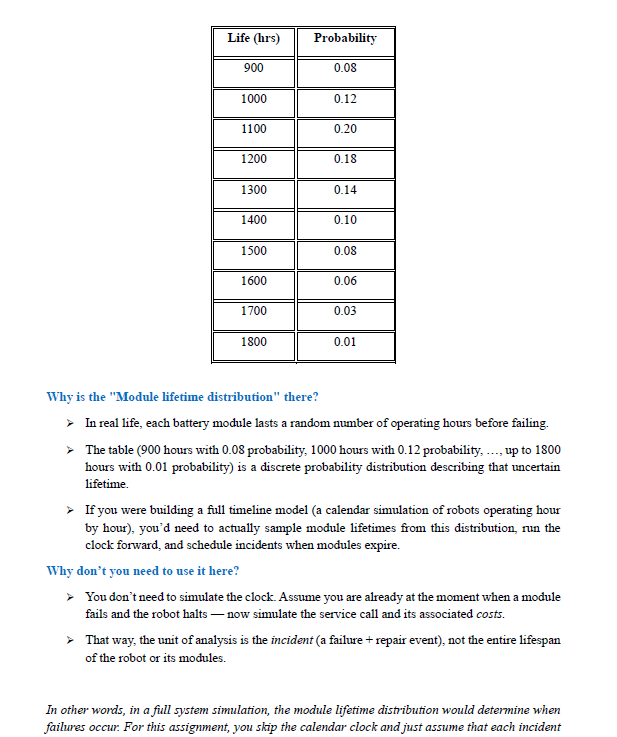

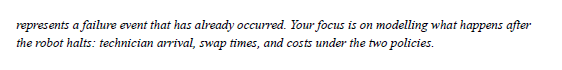

**(a)	Simulation model design (Excel or pseudocode)**

---
Design two parallel models:
1.	Current Policy: Replace only the failed module.
2.	Proposed Policy: Replace all three modules whenever one fails.
    For Each Incident:


* Randomly sample arrival delay and swap time (depending on # modules replaced).
* Compute downtime minutes = arrival delay + swap time.
* Compute labour cost = (swap time in minutes / 60) × $35.

* Compute downtime cost = downtime minutes × $12.

* Compute parts cost = $85 × (# modules replaced).

Aggregate totals over 50 incidents, then compare policies on:



*   Total cost
*   Avg. downtime per incident


*   Proportion of time spent waiting (arrival) vs. repairing (swap)











In [ ]:
# Import Libraries
import random
import pandas as pd
import numpy as np


In [ ]:
# Task (a): Implementation
import random
import pandas as pd

# Constants
PART_COST = 85
DOWNTIME_RATE = 12        # $/min
LABOUR_RATE = 35          # $/hour
SWAP_MIN = {1: 15, 2: 24, 3: 32}

def sample_arrival_delay():
    r = random.randint(1, 100)
    if r <= 55:
        return 10
    elif r <= 85:
        return 20
    else:
        return 35

def one_incident(k_modules: int):
    arrival = sample_arrival_delay()
    swap = SWAP_MIN[k_modules]
    downtime = arrival + swap
    labour_cost = (swap / 60) * LABOUR_RATE
    downtime_cost = downtime * DOWNTIME_RATE
    parts_cost = k_modules * PART_COST
    total_cost = labour_cost + downtime_cost + parts_cost
    return arrival, swap, downtime, labour_cost, downtime_cost, parts_cost, total_cost

def simulate(policy_name: str, k_modules: int, n_incidents: int = 50, seed: int = 123):
    random.seed(seed)
    sum_arr = sum_swap = 0
    sum_lab = sum_down = sum_parts = sum_total = 0.0

    for _ in range(n_incidents):
        a, s, d, c_lab, c_down, c_parts, c_tot = one_incident(k_modules)
        sum_arr += a; sum_swap += s
        sum_lab += c_lab; sum_down += c_down; sum_parts += c_parts; sum_total += c_tot

    avg_dt = (sum_arr + sum_swap) / n_incidents
    wait_share = sum_arr / (sum_arr + sum_swap)
    repair_share = sum_swap / (sum_arr + sum_swap)

    return {
        "policy": policy_name,
        "incidents": n_incidents,
        "total_cost": round(sum_total, 2),
        "avg_downtime_min": round(avg_dt, 2),
        "waiting_share": round(wait_share, 4),
        "repair_share": round(repair_share, 4),
        "labour_cost": round(sum_lab, 2),
        "downtime_cost": round(sum_down, 2),
        "parts_cost": round(sum_parts, 2),
    }

# Run two parallel models (Current vs Proposed) over 50 incidents each
current_summary = simulate("Current", k_modules=1, n_incidents=50, seed=123)
proposed_summary = simulate("Proposed", k_modules=3, n_incidents=50, seed=123)

# Show comparison table
summary_df = pd.DataFrame([current_summary, proposed_summary]).sort_values("policy").reset_index(drop=True)
summary_df

,policy,incidents,total_cost,avg_downtime_min,waiting_share,repair_share,labour_cost,downtime_cost,parts_cost
0,Current,50,22687.50,30.0,0.5000,0.5000,437.50,18000.0,4250.0
1,Proposed,50,41883.33,47.0,0.3191,0.6809,933.33,28200.0,12750.0


**(b)	Python script (Monte Carlo)**

Write a Python script to:


*   
Simulate 50 incidents under each policy.
*Repeat the 50-incident experiment R = 5,000 times to estimate expected cost and 95% CIs.

*   Report for each policy:
     
o	Mean total cost and 95% CI (confidence interval) (read below)

o	Mean downtime per incident

o	Cost breakdown: parts, labour, downtime

**Note:** When you report results, compute a 95% confidence interval for each KPI. A CI gives a range around the sample mean that likely contains the true expected value. For example, if themean cost is $45,200 with a 95% CI of [$44,800, $45,600], we can be reasonably confident that the true expected cost lies  in that interval.

**Statistics hint:**

For a 95% confidence level in the code, use z = 1.96.

Why should you use the z-distribution instead of the t-distribution?

1.	**Classical statistics**


*  The z-distribution (normal) assumes we know the population variance σ².
*  The t-distribution accounts for extra uncertainty when σ² is estimated from a finite sample.

2.	**Simulation context**



*  In Monte Carlo experiments, we often run thousands of replications (e.g., 5,000 in the code).
*  For such a large n (sample size), the t-distribution and z-distribution become nearly indistinguishable, because the t critical value approaches 1.96.


* That’s why many simulation textbooks and papers simply use z as a practical shortcut.

So,

*   If you want rigour, use the t-distribution.
*   If you want simplicity, z is fine for large n, and it keeps the formula cleaner.













In [ ]:
ARRIVAL_VALUES = np.array([10, 20, 35])
ARRIVAL_PROBS  = np.array([0.55, 0.30, 0.15])

# Monte Carlo settings
N_INCIDENTS = 50
R = 5000
Z = 1.96
SEED = 2025
rng = np.random.default_rng(SEED)

def simulate_one_run(modules_replaced: int, rng: np.random.Generator):
    arrivals = rng.choice(ARRIVAL_VALUES, size=N_INCIDENTS, p=ARRIVAL_PROBS)

# Deterministic swap time for this policy
    swap = SWAP_MIN[modules_replaced]
    swaps = np.full(N_INCIDENTS, swap, dtype=int)

# Downtime per incident
    downtime = arrivals + swaps

# Cost components per incident
    labour_cost = (swaps / 60.0) * LABOUR_RATE
    downtime_cost = downtime * DOWNTIME_RATE
    parts_cost = np.full(N_INCIDENTS, modules_replaced * PART_COST)

# Aggregate KPIs for the run
    kpis = {
        "total_cost": labour_cost.sum() + downtime_cost.sum() + parts_cost.sum(),
        "avg_downtime_min": downtime.mean(),
        "labour_cost": labour_cost.sum(),
        "downtime_cost": downtime_cost.sum(),
        "parts_cost": parts_cost.sum(),
    }
    return kpis

def replicate_policy(modules_replaced: int, R: int, rng: np.random.Generator):
    rows = []
    for _ in range(R):
        rows.append(simulate_one_run(modules_replaced, rng))
    return pd.DataFrame(rows)

def mean_and_ci(series: pd.Series, z: float = Z):
    n = len(series)
    mean = series.mean()
    sd = series.std(ddof=1)
    half_width = z * sd / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

# Run Monte Carlo for both policies
df_current = replicate_policy(modules_replaced=1, R=R, rng=rng)
df_proposed = replicate_policy(modules_replaced=3, R=R, rng=rng)

# KPIs summarize
kpis = ["total_cost", "avg_downtime_min", "labour_cost", "downtime_cost", "parts_cost"]

# Build a tidy summary table with mean and 95% CI for each KPI & policy
records = []
for policy_name, df in [("Current", df_current), ("Proposed", df_proposed)]:
    for k in kpis:
        m, lo, hi = mean_and_ci(df[k])
        records.append({
            "Policy": policy_name,
            "KPI": k,
            "Mean": round(m, 2),
            "CI_95_Low": round(lo, 2),
            "CI_95_High": round(hi, 2),
        })

summary_ci = pd.DataFrame(records)

# Display nicely
summary_ci_pivot = (summary_ci
    .pivot(index="KPI", columns="Policy", values="Mean")
    .reindex(kpis)
    .round(2))

print("Means across R = {} replications (50 incidents each)".format(R))
display(summary_ci_pivot)

print("\n 95% Confidence Intervals (z = 1.96)")
summary_ci

Means across R = 5000 replications (50 incidents each)


Policy,Current,Proposed
KPI,,
total_cost,23728.69,42935.40
avg_downtime_min,31.74,48.75
labour_cost,437.50,933.33
downtime_cost,19041.19,29252.06
parts_cost,4250.00,12750.00



 95% Confidence Intervals (z = 1.96)


,Policy,KPI,Mean,CI_95_Low,CI_95_High
0,Current,total_cost,23728.69,23707.77,23749.61
1,Current,avg_downtime_min,31.74,31.70,31.77
2,Current,labour_cost,437.50,437.50,437.50
3,Current,downtime_cost,19041.19,19020.27,19062.11
4,Current,parts_cost,4250.00,4250.00,4250.00
5,Proposed,total_cost,42935.40,42914.53,42956.26
6,Proposed,avg_downtime_min,48.75,48.72,48.79
7,Proposed,labour_cost,933.33,933.33,933.33
8,Proposed,downtime_cost,29252.06,29231.20,29272.93
9,Proposed,parts_cost,12750.00,12750.00,12750.00


(C) **Sensitivity Analysis**


* Change one assumption (e.g., increase downtime cost from $12/min to $15/min, or adjust technician arrival probabilities) and rerun the simulation.
* Compare	how	sensitive	the	policy	recommendation	is	to	this	assumption. This teaches the robustness of decisions.




In [ ]:
# Parameters
N, R = 50, 5000
arrivals, probs = [10,20,35], [0.55,0.30,0.15]
swap = {1:15,3:32}
part_cost, labour_rate = 85, 35

def run_policy(k, downtime_rate):
    rng = np.random.default_rng(123)
    totals, avgs, labs, downs, parts = [],[],[],[],[]
    for _ in range(R):
        a = rng.choice(arrivals, size=N, p=probs)
        s = swap[k]; d = a+s
        lab = (s/60)*labour_rate*N
        down = d.sum()*downtime_rate
        part = k*part_cost*N
        totals.append(lab+down+part); avgs.append(d.mean())
        labs.append(lab); downs.append(down); parts.append(part)
    return pd.DataFrame({"total":totals,"avg_dt":avgs,"lab":labs,"down":downs,"part":parts})

def summary(df):
    return df.mean().round(2).to_dict()

# Baseline (12$/min) vs Modified (15$/min)
cur_base, bun_base = run_policy(1,12), run_policy(3,12)
cur_mod , bun_mod  = run_policy(1,15), run_policy(3,15)

print("Baseline ($12/min) ")
print("Current :", summary(cur_base))
print("Proposed :", summary(bun_base))
print("\nModified ($15/min)")
print("Current :", summary(cur_mod))
print("Proposed :", summary(bun_mod))

Baseline ($12/min) 
Current : {'total': 23747.1, 'avg_dt': 31.77, 'lab': 437.5, 'down': 19059.6, 'part': 4250.0}
Proposed : {'total': 42942.93, 'avg_dt': 48.77, 'lab': 933.33, 'down': 29259.6, 'part': 12750.0}

Modified ($15/min)
Current : {'total': 28512.0, 'avg_dt': 31.77, 'lab': 437.5, 'down': 23824.5, 'part': 4250.0}
Proposed : {'total': 50257.83, 'avg_dt': 48.77, 'lab': 933.33, 'down': 36574.5, 'part': 12750.0}


(d)	**Visualization task**

Use Python libraries such as matplotlib or seaborn to produce the plots to:


* Plot histograms or boxplots of total costs across replications for each policy.

This	will	show	the	distribution	of	outcomes,	not	just	means	and	CIs.


/tmp/ipython-input-4063503871.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Policy", y="TotalCost", palette="pastel", ax=axes[1])


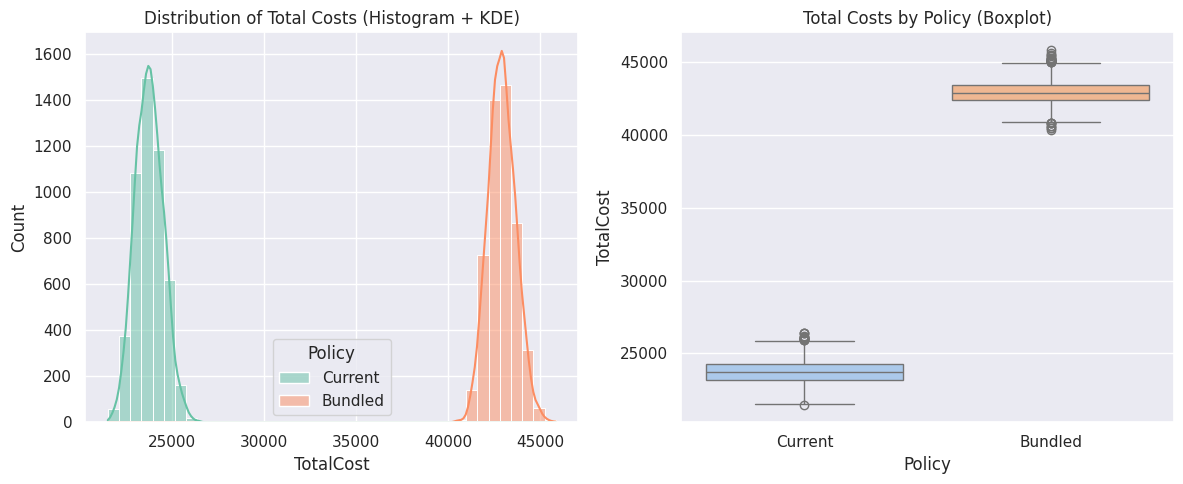

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

N, R = 50, 5000
arrivals, probs = [10,20,35], [0.55,0.30,0.15]
swap, part_cost, labour_rate, downtime_rate = {1:15,3:32}, 85, 35, 12
rng = np.random.default_rng(321)  # different seed for variety

def simulate(k):
    totals=[]
    for _ in range(R):
        a=rng.choice(arrivals,size=N,p=probs)
        s=swap[k]; d=a+s
        lab=(s/60)*labour_rate*N
        down=d.sum()*downtime_rate
        part=k*part_cost*N
        totals.append(lab+down+part)
    return totals

cur_totals, bun_totals = simulate(1), simulate(3)

# Combine into one DataFrame for seaborn
df = pd.DataFrame({
    "TotalCost": cur_totals + bun_totals,
    "Policy": ["Current"]*R + ["Bundled"]*R
})

# Seaborn style & plots
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(1,2,figsize=(12,5))

# Histogram
sns.histplot(df, x="TotalCost", hue="Policy", bins=40, kde=True,
             palette=["#66c2a5","#fc8d62"], alpha=0.5, ax=axes[0])
axes[0].set_title("Distribution of Total Costs (Histogram + KDE)")

# Boxplot
sns.boxplot(data=df, x="Policy", y="TotalCost", palette="pastel", ax=axes[1])
axes[1].set_title("Total Costs by Policy (Boxplot)")

plt.tight_layout(); plt.show()

(E) **Interpretation and recommendations to the management**

**Provide:**

1.	A short executive summary (2–3 sentences, non-technical).
2.	A supporting technical paragraph referencing the CI and cost breakdown.

In [ ]:
# Executive summary + technical recommendation

N,R=50,5000; z=1.96
arr,pr=np.array([10,20,35]),np.array([0.55,0.30,0.15])
swap={1:15,3:32}; PART,LAB,DT=85,35,12
rng=np.random.default_rng(42)

def run(k):
  tots,avgs,labs,downs,parts=[],[],[],[],[]
  for _ in range(R):
    a=rng.choice(arr,size=N,p=pr); s=swap[k]; d=a+s
    lab=(s/60)*LAB*N; down=d.sum()*DT; part=k*PART*N
    tots.append(lab+down+part); avgs.append(d.mean())
    labs.append(lab); downs.append(down); parts.append(part)
  return { "tot":np.array(tots),"avg":np.array(avgs),
           "lab":np.array(labs),"down":np.array(downs),"part":np.array(parts) }

def mean_ci(x): m=x.mean(); hw=z*x.std(ddof=1)/np.sqrt(len(x)); return m,m-hw,m+hw

cur, bun = run(1), run(3)
ct,ctL,ctH=mean_ci(cur["tot"]); bt,btL,btH=mean_ci(bun["tot"])
# Corrected unpacking:
cavg, cavgL, cavgH = mean_ci(cur["avg"]); bavg, bavgL, bavgH = mean_ci(bun["avg"])
cl,cd,cp = cur["lab"].mean(), cur["down"].mean(), cur["part"].mean()
bl,bd,bp = bun["lab"].mean(), bun["down"].mean(), bun["part"].mean()

# Executive summary
print("Executive Summary:")
print(f"An average of the cost of replacing only the failed module will be less expensive and less time consuming than replacing all three. This will help to save the money spend per service call and will shorten average downtime, thus the existing policy should be adopted.\n")

# Technical paragraph
print("Technical Support:")
print(f"Mean total cost per 50 incidents: Current ${ct:,.0f} (95% CI ${ctL:,.0f}–${ctH:,.0f}) vs Proposed ${bt:,.0f} (95% CI ${btL:,.0f}–${btH:,.0f}).\n"
      f"Mean downtime/incident: Current {cavg:.1f} min vs Proposed {bavg:.1f} min.\n"
      f"Cost decomposition (means per 50 incidents): Current → Parts ${cp:,.0f}, Labour ${cl:,.0f}, Downtime ${cd:,.0f};\n"
      f"Proposed → Parts ${bp:,.0f}, Labour ${bl:,.0f}, Downtime ${bd:,.0f}.\n"
      f"Higher swap time and tripled parts under the bundled policy dominate any potential benefit within this incident-level model.")

Executive Summary:
Across many simulated runs, replacing only the failed module is consistently cheaper and faster than replacing all three. This approach lowers both the average downtime and overall spend per service call, so we recommend keeping the current policy.

Technical Support:
Mean total cost per 50 incidents: Current $23,745 (95% CI $23,724–$23,766) vs Proposed $42,900 (95% CI $42,880–$42,921).
Mean downtime/incident: Current 31.8 min vs Proposed 48.7 min.
Cost decomposition (means per 50 incidents): Current → Parts $4,250, Labour $438, Downtime $19,058;
Proposed → Parts $12,750, Labour $933, Downtime $29,217.
Higher swap time and tripled parts under the bundled policy dominate any potential benefit within this incident-level model.


(f)	**Model Assumptions Reflection (short answer, 2–3 sentences)**


* What assumptions did we make by treating each incident as independent? In reality, how could the module lifetime distribution be used in a more detailed simulation?”

In [ ]:
print("Reflection:")
print("We treated events independently, so one failure and ‘fix doesn’t impact when the next event happens or looks to happen. \nIn a more extensive model, practice lifetimes would expand sampled from the given destination to calendar perturbations of phase stoppage, to bundle indorse to dismiss future stoppages. \nThis time-line simulation would be able to pick up long run reliability and policy impacts that incident-only models miss.")

Reflection:
We treated events independently, so one failure and ‘fix doesn’t impact when the next event happens or looks to happen. 
In a more extensive model, practice lifetimes would expand sampled from the given destination to calendar perturbations of phase stoppage, to bundle indorse to dismiss future stoppages. 
This time-line simulation would be able to pick up long run reliability and policy impacts that incident-only models miss.
